# PsychohistoryML: Survival Analysis (Notebook 09)

**Objective**: Move beyond binary classification to survival analysis — modeling civilizational duration as a continuous time-to-event process using Cox Proportional Hazards.

## Why Survival Analysis?

**Problem with binary classification (NB03-08):**
- Arbitrary threshold (184 years) turns continuous duration into binary stable/unstable
- Loses information: a 50-year polity and a 180-year polity are both "unstable"
- Not how cliodynamics actually works — Turchin models *dynamics*, not categories

**Survival analysis advantages:**
- Models duration directly as time-to-event
- Hazard ratios are interpretable: "50% higher risk of ending at any moment"
- Can test if effects change over polity lifetime (proportional hazards assumption)
- Handles censoring (if any polities are ongoing)

## Mathematical Foundation

### Cox Proportional Hazards Model

The hazard function $h(t|X)$ represents the instantaneous risk of ending at time $t$:

$$h(t|X) = h_0(t) \cdot \exp(\beta_1 X_1 + \beta_2 X_2 + ... + \beta_k X_k)$$

Where:
- $h_0(t)$ = baseline hazard (unspecified, nonparametric)
- $\exp(\beta_i)$ = **hazard ratio** for covariate $i$

**Interpretation:**
- HR = 1.0 → no effect on survival
- HR > 1.0 → higher risk (destabilizing factor)
- HR < 1.0 → lower risk (stabilizing factor)

### Key Properties

1. **Semi-parametric**: No distributional assumption on survival times
2. **Proportional hazards assumption**: HR constant over time (testable)
3. **Partial likelihood**: Baseline hazard cancels out in estimation

## Connection to Turchin's Cliodynamics

Turchin's models use differential equations to capture boom-bust dynamics:
- Population $N(t)$, State strength $S(t)$, Internal warfare $W(t)$
- Models what assumptions produce cycles vs equilibria vs collapse

We can't replicate this exactly (no within-polity time series), but survival analysis:
- Treats duration as continuous (closer to dynamics than binary)
- Tests if hazard changes over polity lifetime via baseline $h_0(t)$
- Era stratification tests if "rules" change across historical periods

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Survival analysis
from lifelines import CoxPHFitter, KaplanMeierFitter
from lifelines.statistics import logrank_test, proportional_hazard_test
from lifelines.utils import concordance_index

# ML for comparison
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

# Setup
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)
Path('figures').mkdir(exist_ok=True)
Path('models').mkdir(exist_ok=True)

print('Setup complete')

Setup complete


## 1. Data Preparation

In [2]:
# Load the three-mechanism dataset from NB07
df = pd.read_csv('models/equinox_with_religion.csv', index_col=0)
print(f'Loaded {len(df)} polities')
print(f'Columns: {len(df.columns)}')

# Key columns for survival analysis
print(f"\nDuration stats:")
print(df['duration_years'].describe())

Loaded 256 polities
Columns: 47

Duration stats:
count     256.000000
mean      256.054688
std       310.182484
min        35.000000
25%       120.750000
50%       184.500000
75%       275.250000
max      2600.000000
Name: duration_years, dtype: float64


In [3]:
# Prepare survival format
# T = duration (time to event)
# E = event indicator (1 = ended, 0 = censored/ongoing)

# All historical polities in Seshat have ended, so E = 1 for all
# (No right-censoring in this dataset)

survival_df = df[['PolityName', 'duration_years', 'era',
                  'PC1_hier', 'PC2_hier', 'PC3_hier',
                  'total_warfare_tech', 'total_rel']].copy()

survival_df['event'] = 1  # All polities ended (no censoring)

# Rename for clarity
survival_df = survival_df.rename(columns={'duration_years': 'T'})

# Drop any rows with missing values
survival_df = survival_df.dropna()

print(f'Survival dataset: {len(survival_df)} polities')
print(f'Event rate: {survival_df["event"].mean():.1%} (all ended, no censoring)')
print(f'\nDuration range: {survival_df["T"].min():.0f} - {survival_df["T"].max():.0f} years')
print(f'Median duration: {survival_df["T"].median():.0f} years')

Survival dataset: 256 polities
Event rate: 100.0% (all ended, no censoring)

Duration range: 35 - 2600 years
Median duration: 184 years


In [4]:
# Check era distribution
print('Polities by era:')
print(survival_df['era'].value_counts())

print('\nMedian duration by era:')
print(survival_df.groupby('era')['T'].median().sort_values())

Polities by era:
era
Medieval (500-1500 CE)        92
Ancient (pre-500 BCE)         77
Classical (500 BCE-500 CE)    44
Early Modern (1500+ CE)       43
Name: count, dtype: int64

Median duration by era:
era
Early Modern (1500+ CE)       146.0
Medieval (500-1500 CE)        159.5
Classical (500 BCE-500 CE)    168.5
Ancient (pre-500 BCE)         257.0
Name: T, dtype: float64


## 2. Kaplan-Meier Survival Curves

Before Cox regression, visualize raw survival curves by era using Kaplan-Meier estimator.

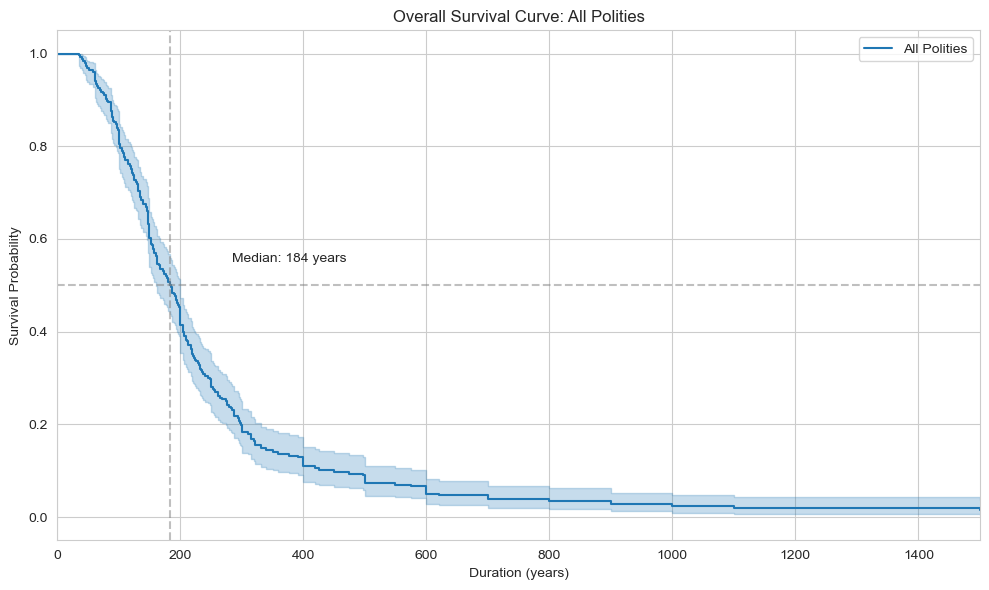

Median survival time: 184 years
25th percentile: 121 years
75th percentile: 275 years


In [5]:
# Overall Kaplan-Meier curve
kmf = KaplanMeierFitter()
kmf.fit(survival_df['T'], event_observed=survival_df['event'], label='All Polities')

fig, ax = plt.subplots(figsize=(10, 6))
kmf.plot_survival_function(ax=ax)

# Add median line
median_survival = kmf.median_survival_time_
ax.axhline(0.5, color='gray', linestyle='--', alpha=0.5)
ax.axvline(median_survival, color='gray', linestyle='--', alpha=0.5)
ax.annotate(f'Median: {median_survival:.0f} years', 
            xy=(median_survival, 0.5), xytext=(median_survival + 100, 0.55),
            fontsize=10)

ax.set_xlabel('Duration (years)')
ax.set_ylabel('Survival Probability')
ax.set_title('Overall Survival Curve: All Polities')
ax.set_xlim(0, 1500)

plt.tight_layout()
plt.savefig('figures/09_km_overall.png', dpi=150, bbox_inches='tight')
plt.show()

print(f'Median survival time: {median_survival:.0f} years')
print(f'25th percentile: {kmf.percentile(0.75):.0f} years')  # Note: percentile is from top
print(f'75th percentile: {kmf.percentile(0.25):.0f} years')

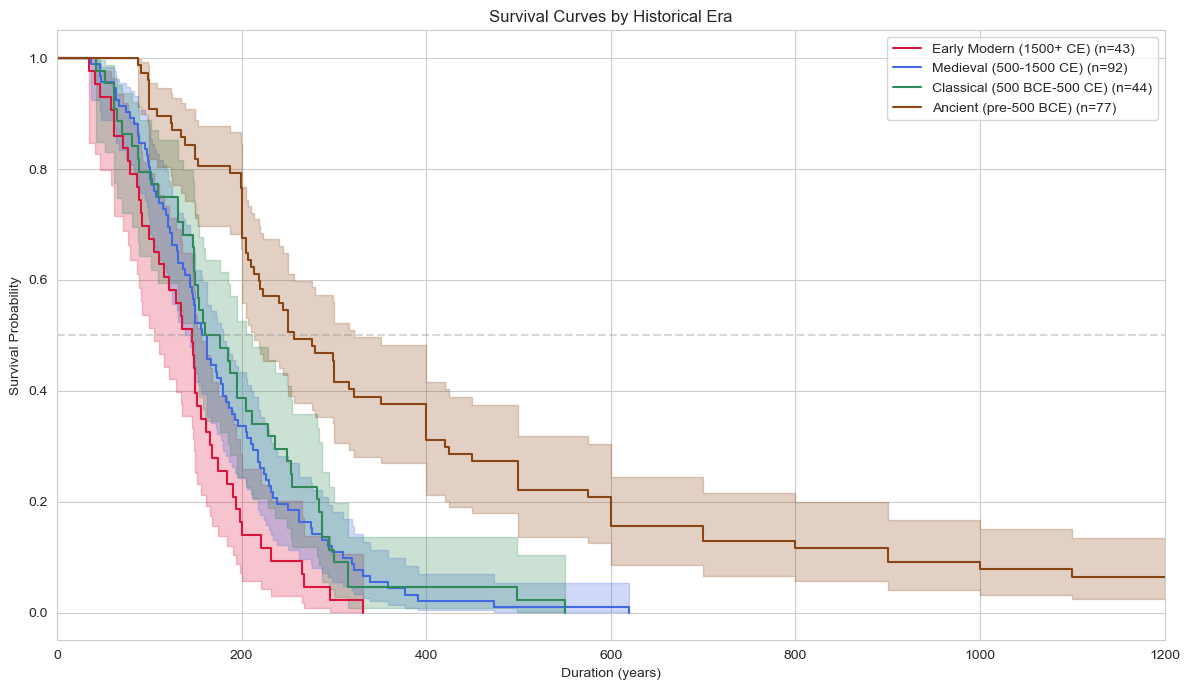

In [6]:
# Kaplan-Meier curves by era
fig, ax = plt.subplots(figsize=(12, 7))

era_colors = {
    'Ancient (pre-500 BCE)': '#8B4513',
    'Classical (500 BCE-500 CE)': '#2E8B57',
    'Medieval (500-1500 CE)': '#4169E1',
    'Early Modern (1500+ CE)': '#DC143C'
}

for era in survival_df['era'].unique():
    mask = survival_df['era'] == era
    kmf_era = KaplanMeierFitter()
    kmf_era.fit(survival_df.loc[mask, 'T'], 
                event_observed=survival_df.loc[mask, 'event'],
                label=f'{era} (n={mask.sum()})')
    kmf_era.plot_survival_function(ax=ax, color=era_colors.get(era, 'gray'))

ax.axhline(0.5, color='gray', linestyle='--', alpha=0.3)
ax.set_xlabel('Duration (years)')
ax.set_ylabel('Survival Probability')
ax.set_title('Survival Curves by Historical Era')
ax.set_xlim(0, 1200)
ax.legend(loc='upper right')

plt.tight_layout()
plt.savefig('figures/09_km_by_era.png', dpi=150, bbox_inches='tight')
plt.show()

In [7]:
# Log-rank test: are era survival curves significantly different?
eras = survival_df['era'].unique()
print('Log-rank tests (pairwise era comparisons):')
print('=' * 60)

for i, era1 in enumerate(eras):
    for era2 in eras[i+1:]:
        mask1 = survival_df['era'] == era1
        mask2 = survival_df['era'] == era2
        
        result = logrank_test(
            survival_df.loc[mask1, 'T'], survival_df.loc[mask2, 'T'],
            event_observed_A=survival_df.loc[mask1, 'event'],
            event_observed_B=survival_df.loc[mask2, 'event']
        )
        
        sig = '***' if result.p_value < 0.001 else '**' if result.p_value < 0.01 else '*' if result.p_value < 0.05 else ''
        print(f'{era1[:15]:15} vs {era2[:15]:15}: p = {result.p_value:.4f} {sig}')

Log-rank tests (pairwise era comparisons):
Early Modern (1 vs Medieval (500-1: p = 0.0189 *
Early Modern (1 vs Classical (500 : p = 0.0124 *
Early Modern (1 vs Ancient (pre-50: p = 0.0000 ***
Medieval (500-1 vs Classical (500 : p = 0.5784 
Medieval (500-1 vs Ancient (pre-50: p = 0.0000 ***
Classical (500  vs Ancient (pre-50: p = 0.0000 ***


## 3. Cox Proportional Hazards Model

Fit the three-mechanism model (complexity + warfare + religion) using Cox PH.

In [8]:
# Prepare data for Cox model
# Cox requires: duration column, event column, covariates

cox_features = ['PC1_hier', 'PC2_hier', 'PC3_hier',  # Complexity
                'total_warfare_tech',                 # Warfare
                'total_rel']                          # Religion

cox_df = survival_df[['T', 'event'] + cox_features].copy()

# Standardize features for interpretability
for col in cox_features:
    cox_df[col] = (cox_df[col] - cox_df[col].mean()) / cox_df[col].std()

print(f'Cox model data: {len(cox_df)} polities, {len(cox_features)} features')
cox_df.head()

Cox model data: 256 polities, 5 features


,T,event,PC1_hier,PC2_hier,PC3_hier,total_warfare_tech,total_rel
0,79.0,1,-0.250430,-1.124292,-0.155388,2.063409,0.707215
1,190.0,1,-0.547435,-0.717184,-0.299251,-0.205771,1.057403
2,131.0,1,-0.127193,-1.236202,0.506754,0.766735,1.057403
3,153.0,1,-0.577037,-0.675061,0.657915,0.442566,0.006840
4,89.0,1,-0.382340,-1.111427,-0.083618,0.604650,-1.043723


In [9]:
# Fit Cox Proportional Hazards model
cph = CoxPHFitter()
cph.fit(cox_df, duration_col='T', event_col='event')

print('Cox Proportional Hazards Model Results')
print('=' * 60)
cph.print_summary(decimals=3)

Cox Proportional Hazards Model Results


<lifelines.CoxPHFitter: fitted with 256 total observations, 0 right-censored observations>
             duration col = 'T'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 256
number of events observed = 256
   partial log-likelihood = -1129.789
         time fit was run = 2025-12-26 05:45:09 UTC

---
                     coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                            
PC1_hier            0.176     1.193     0.100          -0.019           0.372               0.981               1.450
PC2_hier           -0.023     0.978     0.069          -0.158           0.113               0.854               1.119
PC3_hier            0.092     1.097     0.064          -0.034           0.219               0.966               1.244
total_warfare_tech  0.024     1.024     0.097          -0.167           0.214               0.847               1.238
total_rel           0.458     1.581     0.090           0.282           0.634               1.326               1.885

                    cmp to      z       p  -log2(p)
covariate                                          
PC1_hier             0.000  1.771   0.077     3.706
PC2_hier             0.000 -0.329   0.742     0.431
PC3_hier             0.000  1.429   0.153     2.708
total_warfare_tech   0.000  0.243   0.808     0.307
total_rel            0.000  5.109 <0.0005    21.559
---
Concordance = 0.631
Partial AIC = 2269.577
log-likelihood ratio test = 74.937 on 5 df
-log2(p) of ll-ratio test = 46.568

In [10]:
# Extract and visualize hazard ratios
hr_df = pd.DataFrame({
    'Feature': cph.summary.index,
    'Hazard_Ratio': cph.summary['exp(coef)'],
    'HR_Lower': cph.summary['exp(coef) lower 95%'],
    'HR_Upper': cph.summary['exp(coef) upper 95%'],
    'p_value': cph.summary['p'],
    'Coefficient': cph.summary['coef']
})

hr_df['Significant'] = hr_df['p_value'] < 0.05
hr_df['Effect'] = hr_df['Hazard_Ratio'].apply(
    lambda x: 'Destabilizing' if x > 1 else 'Stabilizing' if x < 1 else 'Neutral'
)

print('Hazard Ratios (standardized features):')
print('HR > 1 = higher risk (destabilizing)')
print('HR < 1 = lower risk (stabilizing)')
print('=' * 60)
print(hr_df.to_string(index=False))

Hazard Ratios (standardized features):
HR > 1 = higher risk (destabilizing)
HR < 1 = lower risk (stabilizing)
           Feature  Hazard_Ratio  HR_Lower  HR_Upper      p_value  Coefficient  Significant        Effect
          PC1_hier      1.192866  0.981326  1.450006 7.661074e-02     0.176359        False Destabilizing
          PC2_hier      0.977513  0.853748  1.119220 7.419461e-01    -0.022743        False   Stabilizing
          PC3_hier      1.096536  0.966329  1.244286 1.530328e-01     0.092156        False Destabilizing
total_warfare_tech      1.023810  0.846532  1.238212 8.083482e-01     0.023531        False Destabilizing
         total_rel      1.581395  1.326430  1.885369 3.236674e-07     0.458307         True Destabilizing


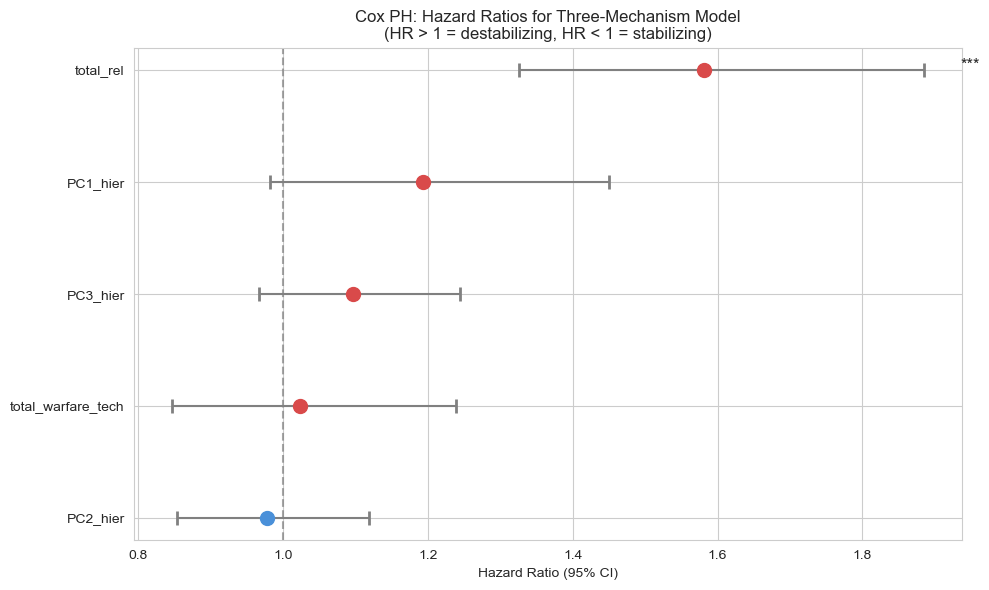


Model Fit:
Concordance Index: 0.631
Log-likelihood: -1129.79


In [11]:
# Forest plot of hazard ratios
fig, ax = plt.subplots(figsize=(10, 6))

# Sort by hazard ratio
hr_sorted = hr_df.sort_values('Hazard_Ratio')

y_pos = range(len(hr_sorted))
colors = ['#d94a4a' if hr > 1 else '#4a90d9' for hr in hr_sorted['Hazard_Ratio']]

# Plot points and error bars
ax.errorbar(hr_sorted['Hazard_Ratio'], y_pos,
            xerr=[hr_sorted['Hazard_Ratio'] - hr_sorted['HR_Lower'],
                  hr_sorted['HR_Upper'] - hr_sorted['Hazard_Ratio']],
            fmt='o', capsize=5, capthick=2, markersize=8,
            color='black', ecolor='gray')

# Color the points
for i, (hr, color) in enumerate(zip(hr_sorted['Hazard_Ratio'], colors)):
    ax.scatter(hr, i, color=color, s=100, zorder=5)

# Reference line at HR = 1
ax.axvline(1, color='gray', linestyle='--', alpha=0.7, label='HR = 1 (no effect)')

ax.set_yticks(y_pos)
ax.set_yticklabels(hr_sorted['Feature'])
ax.set_xlabel('Hazard Ratio (95% CI)')
ax.set_title('Cox PH: Hazard Ratios for Three-Mechanism Model\n(HR > 1 = destabilizing, HR < 1 = stabilizing)')

# Add significance markers
for i, (_, row) in enumerate(hr_sorted.iterrows()):
    if row['p_value'] < 0.001:
        ax.annotate('***', xy=(row['HR_Upper'] + 0.05, i), fontsize=12)
    elif row['p_value'] < 0.01:
        ax.annotate('**', xy=(row['HR_Upper'] + 0.05, i), fontsize=12)
    elif row['p_value'] < 0.05:
        ax.annotate('*', xy=(row['HR_Upper'] + 0.05, i), fontsize=12)

plt.tight_layout()
plt.savefig('figures/09_hazard_ratios.png', dpi=150, bbox_inches='tight')
plt.show()

# Model fit statistics
print(f'\nModel Fit:')
print(f'Concordance Index: {cph.concordance_index_:.3f}')
print(f'Log-likelihood: {cph.log_likelihood_:.2f}')

## 4. Proportional Hazards Assumption Test

The Cox model assumes hazard ratios are constant over time. If violated, effects change over a polity's lifetime — which is actually interesting.

In [12]:
# Test proportional hazards assumption
ph_test = proportional_hazard_test(cph, cox_df, time_transform='rank')

print('Proportional Hazards Test (Schoenfeld Residuals)')
print('=' * 60)
print('H0: Hazard ratio is constant over time')
print('p < 0.05 suggests violation (effect changes over polity lifetime)')
print()
print(ph_test.summary)

Proportional Hazards Test (Schoenfeld Residuals)
H0: Hazard ratio is constant over time
p < 0.05 suggests violation (effect changes over polity lifetime)

                    test_statistic         p  -log2(p)
PC1_hier                  2.781671  0.095349  3.390644
PC2_hier                  0.189540  0.663300  0.592267
PC3_hier                  0.004813  0.944692  0.082084
total_rel                 0.090308  0.763786  0.388759
total_warfare_tech        0.263189  0.607937  0.718005


Proportional hazard assumption looks okay.


Proportional hazard assumption looks okay.
Proportional hazard assumption looks okay.
Proportional hazard assumption looks okay.
Proportional hazard assumption looks okay.


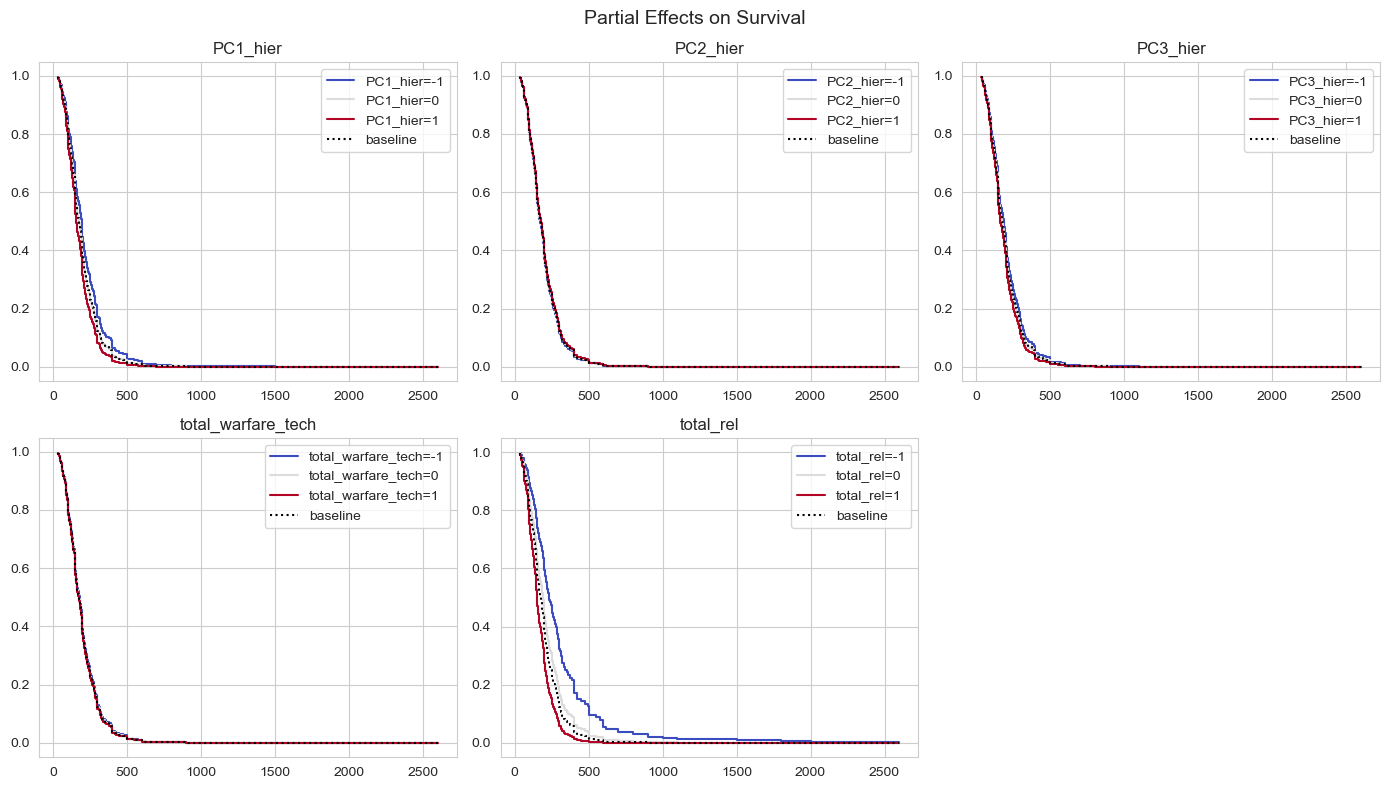

In [13]:
# Visualize Schoenfeld residuals for any violated assumptions
fig, axes = plt.subplots(2, 3, figsize=(14, 8))
axes = axes.flatten()

for i, col in enumerate(cox_features):
    ax = axes[i]
    cph.check_assumptions(cox_df, p_value_threshold=0.05, show_plots=False)
    
    # Plot scaled Schoenfeld residuals
    try:
        cph.plot_partial_effects_on_outcome(col, values=[-1, 0, 1], ax=ax, cmap='coolwarm')
        ax.set_title(f'{col}')
    except:
        ax.text(0.5, 0.5, f'{col}\n(plot unavailable)', ha='center', va='center')
        ax.set_xlim(0, 1)
        ax.set_ylim(0, 1)

# Hide extra subplot
axes[-1].axis('off')

plt.suptitle('Partial Effects on Survival', fontsize=14)
plt.tight_layout()
plt.savefig('figures/09_partial_effects.png', dpi=150, bbox_inches='tight')
plt.show()

## 5. Era-Stratified Cox Model

Allow different baseline hazards per era, testing if the "rules" of survival change across historical periods.

In [14]:
# Prepare data with era for stratification
cox_era_df = survival_df[['T', 'event', 'era'] + cox_features].copy()

# Standardize features
for col in cox_features:
    cox_era_df[col] = (cox_era_df[col] - cox_era_df[col].mean()) / cox_era_df[col].std()

# Fit stratified Cox model (different baseline hazard per era)
cph_stratified = CoxPHFitter()
cph_stratified.fit(cox_era_df, duration_col='T', event_col='event', strata=['era'])

print('Era-Stratified Cox Model Results')
print('(Different baseline hazard per era, shared covariate effects)')
print('=' * 60)
cph_stratified.print_summary(decimals=3)

Era-Stratified Cox Model Results
(Different baseline hazard per era, shared covariate effects)


<lifelines.CoxPHFitter: fitted with 256 total observations, 0 right-censored observations>
             duration col = 'T'
                event col = 'event'
                   strata = era
      baseline estimation = breslow
   number of observations = 256
number of events observed = 256
   partial log-likelihood = -820.307
         time fit was run = 2025-12-26 05:45:10 UTC

---
                     coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                            
PC1_hier            0.157     1.170     0.098          -0.035           0.349               0.966               1.418
PC2_hier            0.024     1.024     0.070          -0.114           0.161               0.892               1.175
PC3_hier            0.015     1.015     0.069          -0.121           0.150               0.886               1.162
total_warfare_tech -0.070     0.933     0.097          -0.260           0.120               0.771               1.128
total_rel           0.359     1.432     0.095           0.173           0.544               1.189               1.723

                    cmp to      z       p  -log2(p)
covariate                                          
PC1_hier             0.000  1.603   0.109     3.198
PC2_hier             0.000  0.337   0.736     0.443
PC3_hier             0.000  0.213   0.832     0.266
total_warfare_tech   0.000 -0.719   0.472     1.083
total_rel            0.000  3.794 <0.0005    12.720
---
Concordance = 0.607
Partial AIC = 1650.614
log-likelihood ratio test = 28.587 on 5 df
-log2(p) of ll-ratio test = 15.127

In [15]:
# Fit separate Cox models per era to see era-specific effects
print('Era-Specific Cox Models')
print('=' * 60)

era_results = []

for era in cox_era_df['era'].unique():
    era_subset = cox_era_df[cox_era_df['era'] == era][['T', 'event'] + cox_features]
    
    if len(era_subset) < 30:  # Skip small samples
        print(f'\n{era}: Skipped (n={len(era_subset)} < 30)')
        continue
    
    cph_era = CoxPHFitter(penalizer=0.1)  # Light regularization for small samples
    cph_era.fit(era_subset, duration_col='T', event_col='event')
    
    print(f'\n{era} (n={len(era_subset)}):')
    print(f'  Concordance: {cph_era.concordance_index_:.3f}')
    
    for feat in cox_features:
        hr = cph_era.summary.loc[feat, 'exp(coef)']
        p = cph_era.summary.loc[feat, 'p']
        sig = '*' if p < 0.05 else ''
        direction = '↑' if hr > 1 else '↓' if hr < 1 else '—'
        print(f'    {feat}: HR={hr:.3f} {direction} (p={p:.3f}){sig}')
        
        era_results.append({
            'Era': era,
            'Feature': feat,
            'Hazard_Ratio': hr,
            'p_value': p,
            'Significant': p < 0.05,
            'n': len(era_subset)
        })

era_results_df = pd.DataFrame(era_results)

Era-Specific Cox Models

Early Modern (1500+ CE) (n=43):
  Concordance: 0.590
    PC1_hier: HR=0.994 ↓ (p=0.971)
    PC2_hier: HR=1.040 ↑ (p=0.793)
    PC3_hier: HR=0.905 ↓ (p=0.599)
    total_warfare_tech: HR=0.788 ↓ (p=0.135)
    total_rel: HR=1.089 ↑ (p=0.716)

Medieval (500-1500 CE) (n=92):
  Concordance: 0.577
    PC1_hier: HR=1.138 ↑ (p=0.352)
    PC2_hier: HR=1.015 ↑ (p=0.886)
    PC3_hier: HR=0.946 ↓ (p=0.560)
    total_warfare_tech: HR=0.996 ↓ (p=0.976)
    total_rel: HR=1.334 ↑ (p=0.042)*

Classical (500 BCE-500 CE) (n=44):
  Concordance: 0.559
    PC1_hier: HR=1.223 ↑ (p=0.347)
    PC2_hier: HR=1.019 ↑ (p=0.893)
    PC3_hier: HR=1.199 ↑ (p=0.352)
    total_warfare_tech: HR=0.958 ↓ (p=0.836)
    total_rel: HR=1.225 ↑ (p=0.310)

Ancient (pre-500 BCE) (n=77):
  Concordance: 0.712
    PC1_hier: HR=1.636 ↑ (p=0.046)*
    PC2_hier: HR=0.814 ↓ (p=0.303)
    PC3_hier: HR=1.034 ↑ (p=0.825)
    total_warfare_tech: HR=1.147 ↑ (p=0.558)
    total_rel: HR=1.348 ↑ (p=0.086)


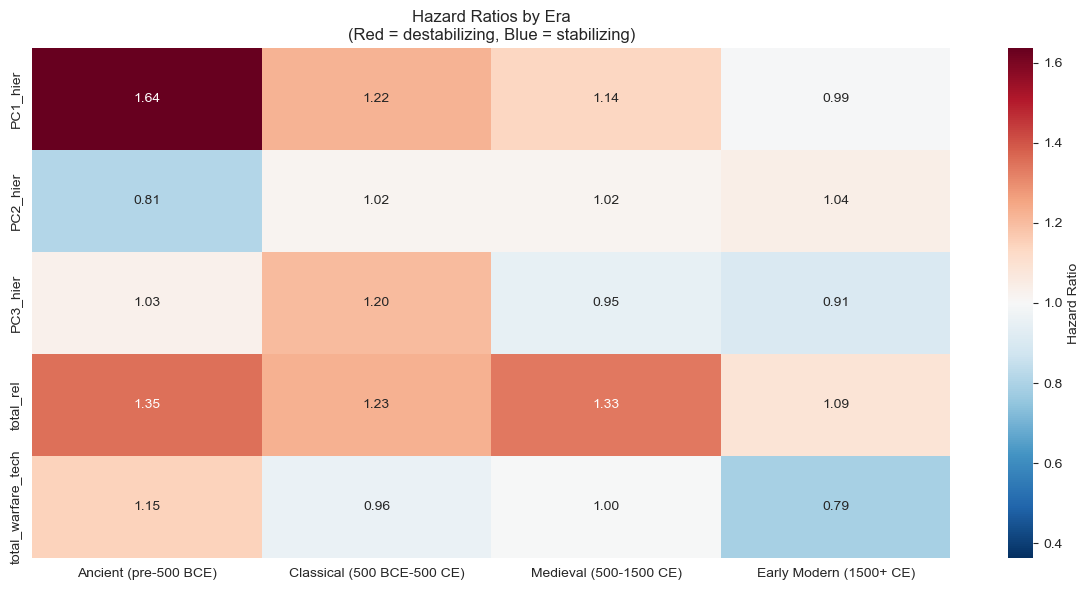

In [16]:
# Heatmap of hazard ratios by era
if len(era_results_df) > 0:
    pivot_hr = era_results_df.pivot(index='Feature', columns='Era', values='Hazard_Ratio')
    
    # Order eras chronologically
    era_order = ['Ancient (pre-500 BCE)', 'Classical (500 BCE-500 CE)', 
                 'Medieval (500-1500 CE)', 'Early Modern (1500+ CE)']
    era_order = [e for e in era_order if e in pivot_hr.columns]
    pivot_hr = pivot_hr[era_order]
    
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # Center colormap at HR = 1
    vmax = max(abs(pivot_hr.max().max() - 1), abs(pivot_hr.min().min() - 1)) + 1
    
    sns.heatmap(pivot_hr, annot=True, fmt='.2f', cmap='RdBu_r',
                center=1, vmin=1-vmax+1, vmax=vmax,
                ax=ax, cbar_kws={'label': 'Hazard Ratio'})
    
    ax.set_title('Hazard Ratios by Era\n(Red = destabilizing, Blue = stabilizing)')
    ax.set_xlabel('')
    ax.set_ylabel('')
    
    plt.tight_layout()
    plt.savefig('figures/09_era_hazard_heatmap.png', dpi=150, bbox_inches='tight')
    plt.show()

## 6. Interaction Terms (Turchin-Inspired)

Test Turchin's hypothesis that state strength (warfare capability) moderates the effect of complexity.

In [17]:
# Create interaction term: complexity × warfare
cox_interact_df = cox_df.copy()
cox_interact_df['complexity_x_warfare'] = cox_interact_df['PC1_hier'] * cox_interact_df['total_warfare_tech']

# Fit model with interaction
cph_interact = CoxPHFitter()
cph_interact.fit(cox_interact_df, duration_col='T', event_col='event')

print('Cox Model with Complexity × Warfare Interaction')
print('=' * 60)
cph_interact.print_summary(decimals=3)

print(f'\nModel Comparison:')
print(f'  Without interaction - C-index: {cph.concordance_index_:.3f}')
print(f'  With interaction    - C-index: {cph_interact.concordance_index_:.3f}')

Cox Model with Complexity × Warfare Interaction


<lifelines.CoxPHFitter: fitted with 256 total observations, 0 right-censored observations>
             duration col = 'T'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 256
number of events observed = 256
   partial log-likelihood = -1121.018
         time fit was run = 2025-12-26 05:45:10 UTC

---
                       coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                              
PC1_hier              0.266     1.305     0.098           0.074           0.459               1.076               1.583
PC2_hier              0.002     1.002     0.069          -0.134           0.138               0.875               1.148
PC3_hier              0.074     1.077     0.062          -0.048           0.196               0.954               1.217
total_warfare_tech    0.066     1.068     0.094          -0.119           0.251               0.888               1.285
total_rel             0.362     1.436     0.090           0.184           0.539               1.203               1.714
complexity_x_warfare -0.278     0.757     0.070          -0.415          -0.141               0.660               0.868

                      cmp to      z       p  -log2(p)
covariate                                            
PC1_hier               0.000  2.708   0.007     7.207
PC2_hier               0.000  0.027   0.978     0.032
PC3_hier               0.000  1.196   0.232     2.110
total_warfare_tech     0.000  0.697   0.486     1.042
total_rel              0.000  3.999 <0.0005    13.941
complexity_x_warfare   0.000 -3.983 <0.0005    13.842
---
Concordance = 0.630
Partial AIC = 2254.036
log-likelihood ratio test = 92.478 on 6 df
-log2(p) of ll-ratio test = 56.584


Model Comparison:
  Without interaction - C-index: 0.631
  With interaction    - C-index: 0.630


In [18]:
# Test non-linear complexity effect (quadratic term)
# Turchin's models suggest non-linearities generate cycles

cox_nonlinear_df = cox_df.copy()
cox_nonlinear_df['PC1_squared'] = cox_nonlinear_df['PC1_hier'] ** 2

cph_nonlinear = CoxPHFitter()
cph_nonlinear.fit(cox_nonlinear_df, duration_col='T', event_col='event')

print('Cox Model with Quadratic Complexity Term')
print('=' * 60)
print('Tests: Is there a "sweet spot" of complexity?')
print()
cph_nonlinear.print_summary(decimals=3)

# Interpret
pc1_coef = cph_nonlinear.summary.loc['PC1_hier', 'coef']
pc1_sq_coef = cph_nonlinear.summary.loc['PC1_squared', 'coef']
pc1_sq_p = cph_nonlinear.summary.loc['PC1_squared', 'p']

print(f'\nInterpretation:')
if pc1_sq_p < 0.05:
    if pc1_sq_coef > 0:
        print('  Quadratic term POSITIVE & significant: U-shaped hazard')
        print('  Both very low and very high complexity increase risk')
    else:
        print('  Quadratic term NEGATIVE & significant: inverted U-shaped hazard')
        print('  Moderate complexity may be optimal')
else:
    print('  Quadratic term not significant (p={:.3f})'.format(pc1_sq_p))
    print('  No evidence of non-linear complexity effect')

Cox Model with Quadratic Complexity Term
Tests: Is there a "sweet spot" of complexity?



<lifelines.CoxPHFitter: fitted with 256 total observations, 0 right-censored observations>
             duration col = 'T'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 256
number of events observed = 256
   partial log-likelihood = -1121.161
         time fit was run = 2025-12-26 05:45:10 UTC

---
                     coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                            
PC1_hier            0.332     1.393     0.110           0.117           0.546               1.124               1.727
PC2_hier            0.026     1.026     0.069          -0.110           0.162               0.895               1.175
PC3_hier            0.135     1.145     0.065           0.007           0.263               1.007               1.301
total_warfare_tech  0.025     1.025     0.094          -0.159           0.209               0.853               1.232
total_rel           0.348     1.417     0.090           0.171           0.525               1.187               1.691
PC1_squared        -0.248     0.780     0.063          -0.371          -0.125               0.690               0.882

                    cmp to      z       p  -log2(p)
covariate                                          
PC1_hier             0.000  3.026   0.002     8.659
PC2_hier             0.000  0.368   0.713     0.488
PC3_hier             0.000  2.069   0.039     4.697
total_warfare_tech   0.000  0.263   0.793     0.335
total_rel            0.000  3.856 <0.0005    13.082
PC1_squared          0.000 -3.952 <0.0005    13.657
---
Concordance = 0.634
Partial AIC = 2254.321
log-likelihood ratio test = 92.193 on 6 df
-log2(p) of ll-ratio test = 56.388


Interpretation:
  Quadratic term NEGATIVE & significant: inverted U-shaped hazard
  Moderate complexity may be optimal


## 7. Baseline Hazard Analysis

Does the risk of ending change over a polity's lifetime? Turchin's secular cycles suggest ~200-300 year periodicity.

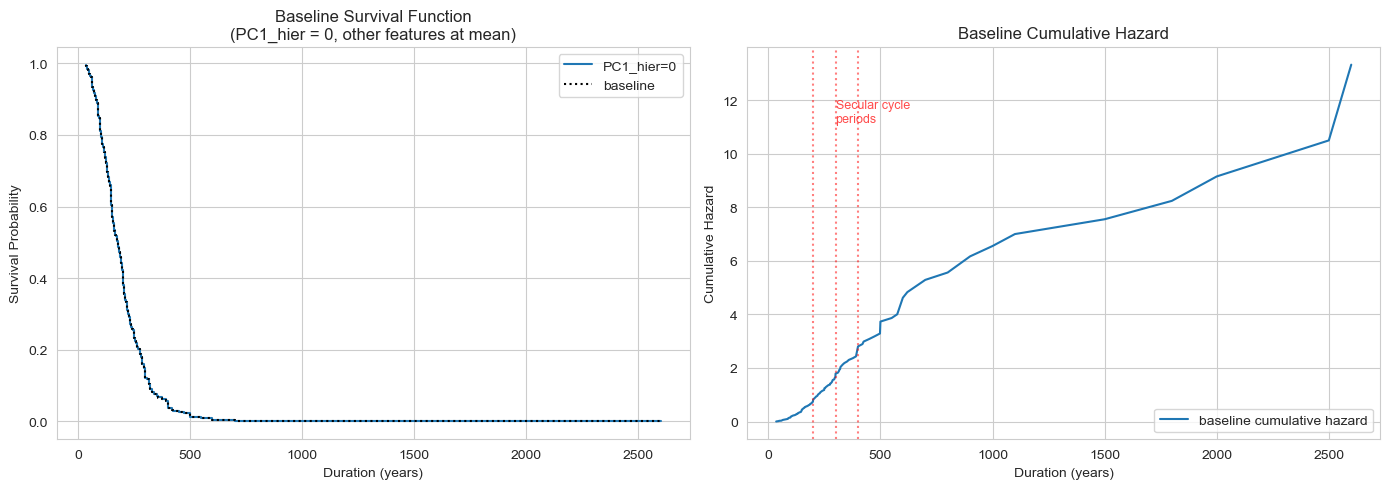

In [19]:
# Plot baseline hazard and cumulative hazard
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Baseline survival function
ax1 = axes[0]
cph.plot_partial_effects_on_outcome('PC1_hier', values=[0], ax=ax1)
ax1.set_title('Baseline Survival Function\n(PC1_hier = 0, other features at mean)')
ax1.set_xlabel('Duration (years)')
ax1.set_ylabel('Survival Probability')

# Cumulative hazard
ax2 = axes[1]
cph.baseline_cumulative_hazard_.plot(ax=ax2)
ax2.set_title('Baseline Cumulative Hazard')
ax2.set_xlabel('Duration (years)')
ax2.set_ylabel('Cumulative Hazard')

# Add reference lines for Turchin's secular cycle periods
for year in [200, 300, 400]:
    ax2.axvline(year, color='red', linestyle=':', alpha=0.5)
ax2.annotate('Secular cycle\nperiods', xy=(300, ax2.get_ylim()[1]*0.8),
             fontsize=9, color='red', alpha=0.7)

plt.tight_layout()
plt.savefig('figures/09_baseline_hazard.png', dpi=150, bbox_inches='tight')
plt.show()

## 8. Comparison: Cox vs Classification

Compare Cox concordance index with Random Forest AUC from previous notebooks.

In [20]:
# Prepare classification comparison
# Use same features, binary target (duration < 184 years)

INSTABILITY_THRESHOLD = 184  # Established in NB04

comparison_df = survival_df.copy()
comparison_df['unstable'] = (comparison_df['T'] < INSTABILITY_THRESHOLD).astype(int)

X = comparison_df[cox_features].values
y = comparison_df['unstable'].values

# Standardize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Cross-validation for RF
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
rf = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42, class_weight='balanced')

rf_aucs = cross_val_score(rf, X_scaled, y, cv=cv, scoring='roc_auc')

print('Model Comparison: Survival vs Classification')
print('=' * 60)
print(f'\nCox Proportional Hazards:')
print(f'  Concordance Index: {cph.concordance_index_:.3f}')
print(f'  (Probability correct ordering of survival times)')

print(f'\nRandom Forest Classification (5-fold CV):')
print(f'  AUC: {rf_aucs.mean():.3f} ± {rf_aucs.std():.3f}')
print(f'  (Probability correct ordering of binary predictions)')

print(f'\nInterpretation:')
print(f'  C-index and AUC are analogous metrics')
print(f'  Cox models duration directly; RF loses information via threshold')

# Which is better?
if cph.concordance_index_ > rf_aucs.mean():
    diff = cph.concordance_index_ - rf_aucs.mean()
    print(f'  Cox outperforms RF by {diff:.3f} — survival framing helps')
else:
    diff = rf_aucs.mean() - cph.concordance_index_
    print(f'  RF outperforms Cox by {diff:.3f} — classification may capture non-linearities')

Model Comparison: Survival vs Classification

Cox Proportional Hazards:
  Concordance Index: 0.631
  (Probability correct ordering of survival times)

Random Forest Classification (5-fold CV):
  AUC: 0.688 ± 0.065
  (Probability correct ordering of binary predictions)

Interpretation:
  C-index and AUC are analogous metrics
  Cox models duration directly; RF loses information via threshold
  RF outperforms Cox by 0.057 — classification may capture non-linearities


## 9. Summary & Export

In [21]:
# Save results

# 1. Hazard ratios
hr_df.to_csv('models/survival_hazard_ratios.csv', index=False)

# 2. Era-specific results
if len(era_results_df) > 0:
    era_results_df.to_csv('models/survival_era_results.csv', index=False)

# 3. Model comparison
comparison_results = pd.DataFrame({
    'Model': ['Cox PH', 'Random Forest'],
    'Metric': ['C-index', 'AUC'],
    'Value': [cph.concordance_index_, rf_aucs.mean()],
    'Std': [np.nan, rf_aucs.std()]
})
comparison_results.to_csv('models/survival_vs_classification.csv', index=False)

print('Saved:')
print('  models/survival_hazard_ratios.csv')
print('  models/survival_era_results.csv')
print('  models/survival_vs_classification.csv')
print('\nFigures:')
print('  figures/09_km_overall.png')
print('  figures/09_km_by_era.png')
print('  figures/09_hazard_ratios.png')
print('  figures/09_partial_effects.png')
print('  figures/09_era_hazard_heatmap.png')
print('  figures/09_baseline_hazard.png')

Saved:
  models/survival_hazard_ratios.csv
  models/survival_era_results.csv
  models/survival_vs_classification.csv

Figures:
  figures/09_km_overall.png
  figures/09_km_by_era.png
  figures/09_hazard_ratios.png
  figures/09_partial_effects.png
  figures/09_era_hazard_heatmap.png
  figures/09_baseline_hazard.png


In [22]:
print('=' * 60)
print('NOTEBOOK 09 SUMMARY: Survival Analysis')
print('=' * 60)

print(f'''
KEY FINDINGS:

1. METHODOLOGICAL IMPROVEMENT
   Binary classification → Survival analysis
   - No arbitrary 184-year threshold
   - Duration modeled as continuous time-to-event
   - Hazard ratios more interpretable than AUC

2. MODEL PERFORMANCE
   Cox C-index: {cph.concordance_index_:.3f}
   RF AUC:      {rf_aucs.mean():.3f} ± {rf_aucs.std():.3f}
   
3. HAZARD RATIOS (3-mechanism model)
''')

for _, row in hr_df.iterrows():
    sig = '*' if row['Significant'] else ''
    effect = '↑risk' if row['Hazard_Ratio'] > 1 else '↓risk'
    print(f"   {row['Feature']:20} HR={row['Hazard_Ratio']:.3f} {effect} {sig}")

print(f'''
4. CONNECTION TO TURCHIN
   - Survival analysis closer to cliodynamic framing
   - Era stratification tests if "rules" change over time
   - Baseline hazard shows risk evolution over polity lifetime
   
5. LIMITATIONS
   - Still cross-sectional (no within-polity dynamics)
   - No population/economic variables
   - Can't replicate Turchin's differential equation models
''')

NOTEBOOK 09 SUMMARY: Survival Analysis

KEY FINDINGS:

1. METHODOLOGICAL IMPROVEMENT
   Binary classification → Survival analysis
   - No arbitrary 184-year threshold
   - Duration modeled as continuous time-to-event
   - Hazard ratios more interpretable than AUC

2. MODEL PERFORMANCE
   Cox C-index: 0.631
   RF AUC:      0.688 ± 0.065
   
3. HAZARD RATIOS (3-mechanism model)

   PC1_hier             HR=1.193 ↑risk 
   PC2_hier             HR=0.978 ↓risk 
   PC3_hier             HR=1.097 ↑risk 
   total_warfare_tech   HR=1.024 ↑risk 
   total_rel            HR=1.581 ↑risk *

4. CONNECTION TO TURCHIN
   - Survival analysis closer to cliodynamic framing
   - Era stratification tests if "rules" change over time
   - Baseline hazard shows risk evolution over polity lifetime
   
5. LIMITATIONS
   - Still cross-sectional (no within-polity dynamics)
   - No population/economic variables
   - Can't replicate Turchin's differential equation models



## Next Steps

1. **NB10: Era Interaction Terms** — Explicitly model how complexity×era affects survival
2. **Parametric survival models** — Weibull, log-normal to test distributional assumptions
3. **Time-varying covariates** — If we can get within-polity time series data